<a href="https://colab.research.google.com/github/suchy1713/EmotionPredicition/blob/master/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import pandas as pd
pd.set_option('display.max_columns', 500)

df = pd.read_csv('https://raw.githubusercontent.com/suchy1713/EmotionPredicition/master/data/preprocessed/merged.csv')

#drop emospace answers
df = df.drop(df[df['WIDGET-TYPE'] == 'emospace1'].index)

#drop useless features
df = df.drop(['TIMESTAMP', 'WIDGET-TYPE', 'COND', 'ANS-TIME', 'IADS-ID', 'IAPS-ID', 'ID', 'PROCEDURE-BEGIN-TIMESTAMP', 'PROCEDURE-END-TIMESTAMP', 'BIOSIGS-BEGIN-TIMESTAMP', 'BIOSIGS-END-TIMESTAMP', 'NEO-FFI', 'BIOSIGS', 'PROCEDURE', 'SPACE', 'FREUD', 'PHOTOS'], axis=1)

df.head()

,COND-DETAILS,ANS,AGE,SEX,OPENNESS,CONSCIENTIOUSNESS,EXTRAVERSION,AGREEABLENESS,NEUROTICISM
60,p0s0,2.0,21.0,F,4.0,6.0,10.0,4.0,3.0
61,p-s+,2.0,21.0,F,4.0,6.0,10.0,4.0,3.0
62,p+s-,4.0,21.0,F,4.0,6.0,10.0,4.0,3.0
63,p-s-,3,21.0,F,4.0,6.0,10.0,4.0,3.0
64,p-s+,2.0,21.0,F,4.0,6.0,10.0,4.0,3.0


This is our dirty data. First of all, we should look for missing values. Let's visualize them.

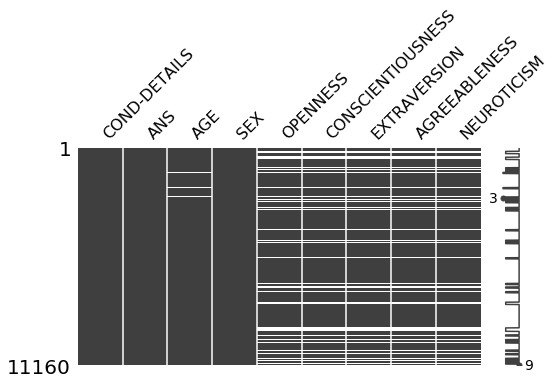

In [128]:
import missingno as mn
mn.matrix(df, figsize=(8,4))

The 'age' column has a couple of missing values, however it's manageable. The major problem though, lies within the personality traits data. It seems like if the one trait is missing, the others are missing as well. We can confirm this correlation using the dendrogram.

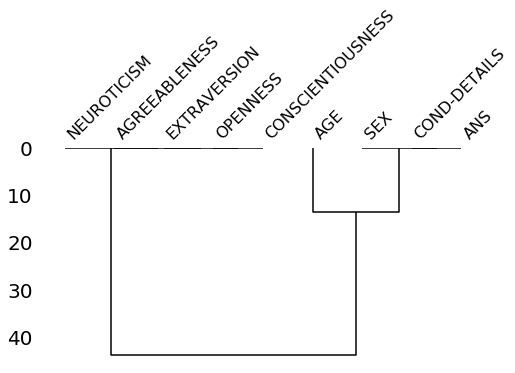

In [129]:
mn.dendrogram(df, figsize=(8,4))

And finally we will plot actual numbers to see whether we should replace missing values or drop whole features.

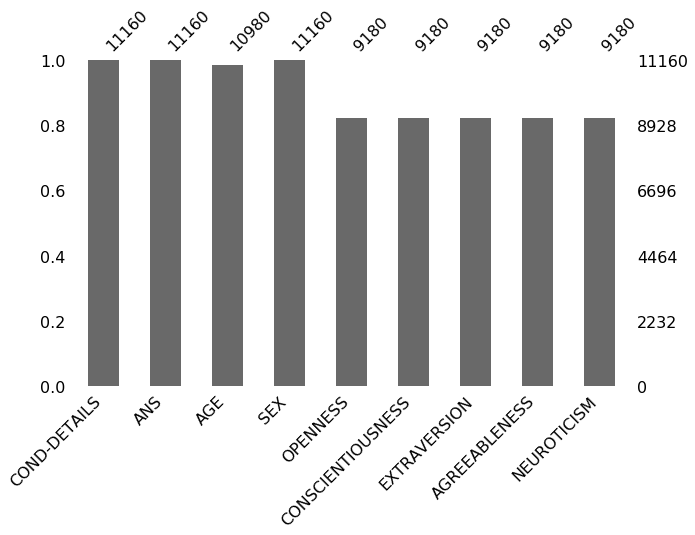

In [130]:
mn.bar(df, figsize=(10,6))

Psychological traits are missing in around 20% of the cases. It's still acceptable. If they carry any meaning, it's better to replace missing values than not use them at all.

Before dealing with them, let's encode categorical data. Firstly, we will inspect possible values.

In [131]:
print(df['SEX'].value_counts(), '\n')
print(df['COND-DETAILS'].value_counts(), '\n')
print(df['ANS'].value_counts(), '\n')

M    7740
F    3420
Name: SEX, dtype: int64 

p-s+    2826
p+s-    2708
p+s+    1909
p-s-    1877
p0s0    1840
Name: COND-DETAILS, dtype: int64 

2.0    3248
4.0    2406
3      2401
1.0    1954
5.0     857
3.0     294
Name: ANS, dtype: int64 



There is an issue in the 'ANS' column. We have two different values that seem to correspond to the same category. Let's merge them and actually encode. Also, we will drop one of the columns from each feature to prevent data redundancy.

In [132]:
#merge
df['ANS'] = df['ANS'].replace('3', '3.0')

#encode
df = pd.get_dummies(df, columns=['COND-DETAILS', 'SEX'], drop_first=True)
df = pd.get_dummies(df, columns=['ANS'], drop_first=False)

df.head()

,AGE,OPENNESS,CONSCIENTIOUSNESS,EXTRAVERSION,AGREEABLENESS,NEUROTICISM,COND-DETAILS_p+s-,COND-DETAILS_p-s+,COND-DETAILS_p-s-,COND-DETAILS_p0s0,SEX_M,ANS_1.0,ANS_2.0,ANS_3.0,ANS_4.0,ANS_5.0
60,21.0,4.0,6.0,10.0,4.0,3.0,0,0,0,1,0,0,1,0,0,0
61,21.0,4.0,6.0,10.0,4.0,3.0,0,1,0,0,0,0,1,0,0,0
62,21.0,4.0,6.0,10.0,4.0,3.0,1,0,0,0,0,0,0,0,1,0
63,21.0,4.0,6.0,10.0,4.0,3.0,0,0,1,0,0,0,0,1,0,0
64,21.0,4.0,6.0,10.0,4.0,3.0,0,1,0,0,0,0,1,0,0,0


Now onto the missing values. We will replace them with medians from corresponding columns.

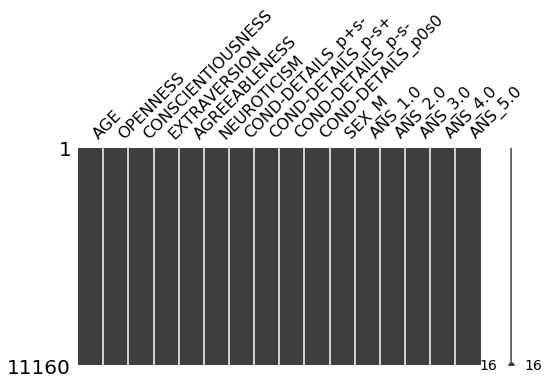

In [133]:
from sklearn.impute import SimpleImputer
import numpy as np

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_df = pd.DataFrame(imputer.fit_transform(df))
imputed_df.columns = df.columns
imputed_df.index = df.index
df = imputed_df

mn.matrix(df, figsize=(8,4))

Outliers in the data may indicate incorrect values and cause problems for algorithms. Let's plot our real features to see if that's the case.

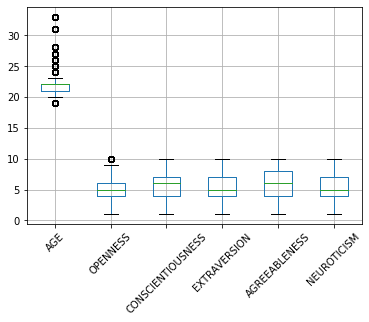

In [134]:
df.boxplot(column=['AGE', 'OPENNESS', 'CONSCIENTIOUSNESS', 'EXTRAVERSION', 'AGREEABLENESS', 'NEUROTICISM'], rot=45)

There is no obvious mistakes in the data. Age outliers shouldn't be a problem. 

ML algorithms work better with features on a relatively small scale. We should normalize our data then. MinMaxScaler will translate each feature individually to the range (0, 1).

In [136]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df.head()

,AGE,OPENNESS,CONSCIENTIOUSNESS,EXTRAVERSION,AGREEABLENESS,NEUROTICISM,COND-DETAILS_p+s-,COND-DETAILS_p-s+,COND-DETAILS_p-s-,COND-DETAILS_p0s0,SEX_M,ANS_1.0,ANS_2.0,ANS_3.0,ANS_4.0,ANS_5.0
0,0.142857,0.333333,0.555556,1.0,0.333333,0.222222,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.142857,0.333333,0.555556,1.0,0.333333,0.222222,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.142857,0.333333,0.555556,1.0,0.333333,0.222222,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.142857,0.333333,0.555556,1.0,0.333333,0.222222,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.142857,0.333333,0.555556,1.0,0.333333,0.222222,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Now let's see how features corelate with each other. This will let us capture strong corelations and prevent multicollinearity (happens when one feature can be linearly predicted from the others with high accuracy).

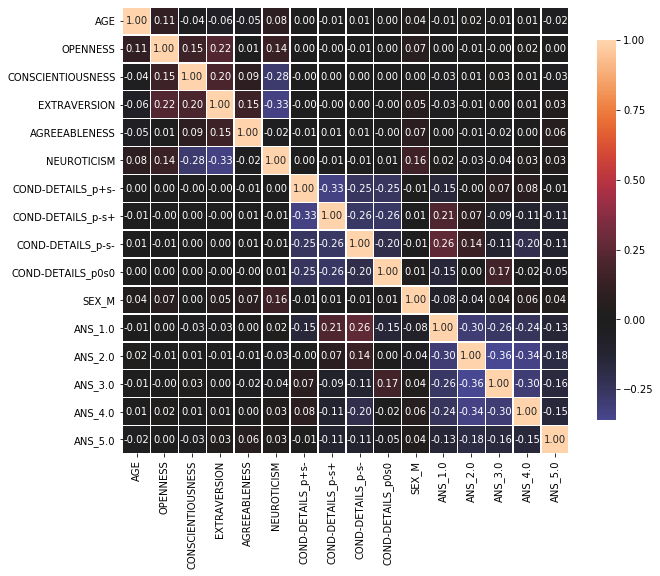

In [137]:
#plot correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();

There are no strong corelations (<-0.9 || >0.9) therefore we don't need to get rid of any features.

Now, for the sake of presentation, let's reduce dimentionality and plot our data.

Variance:  0.3958654253787522


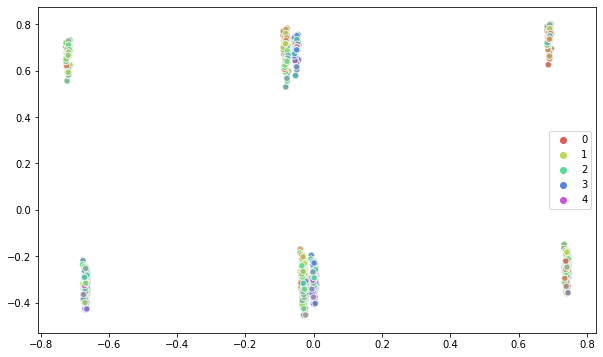

In [140]:
#principal component analysis
from sklearn.decomposition import PCA

X = df.values[:, :11]
Y = df.values[:, 11:]
y = Y.argmax(axis=1)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

print("Variance: ", pca.explained_variance_ratio_.sum())

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=y,
    palette=sns.color_palette("hls", 5),
    legend='full',
    alpha=0.3
)

Two generated features account for about 40% of variance in the entire dataset. We can see that 8 clusters formed but they don't correspond to target classes in any way. We are not able to distinguish them visually.

Going a step further, seven features account for 89% of variance. We could just feed them to our algorithms (to speed-up the training process and minimize the risk of overfitting) but this would significantly harm our ability to explain the results. We don't want to give away 6 points so we'll stick to the full data.

And for the last step, let's shuffle and export preprocessed data.

In [0]:
df = df.sample(frac=1)
df.to_csv('data.csv', index=False)